# SVM binary classification
- 인디언 당뇨병 데이터 셋을 이용해서 당뇨병 여부 예측

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42

# 1. 데이터 준비

In [2]:
# !wget https://raw.githubusercontent.com/devdio/flyai_datasets/main/diabetes.csv

--2024-07-07 11:54:37--  https://raw.githubusercontent.com/devdio/flyai_datasets/main/diabetes.csv
raw.githubusercontent.com (raw.githubusercontent.com) 해석 중... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
다음으로 연결 중: raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 200 OK
길이: 23873 (23K) [text/plain]
저장 위치: `diabetes.csv'

diabetes.csv        100%[===================>]  23.31K  --.-KB/s    /  0.02s   

2024-07-07 11:54:38 (1.09 MB/s) - `diabetes.csv' 저장함 [23873/23873]



In [3]:
diabetes = pd.read_csv('diabetes.csv')
diabetes.shape

(768, 9)

In [4]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df = diabetes.copy()
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [7]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [8]:
df['Outcome'].value_counts() # 데이터 불균형을 확인하기 위해 봐야하는 과정

Outcome
0    500
1    268
Name: count, dtype: int64

<Axes: xlabel='Outcome', ylabel='count'>

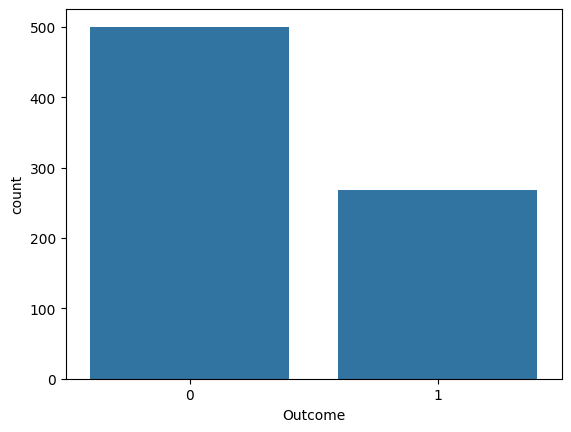

In [9]:
sns.countplot(x='Outcome', data=df)

## 연속형 변수

In [10]:
tmp = df['Pregnancies'].sort_values(ascending=False)

<Axes: xlabel='None'>

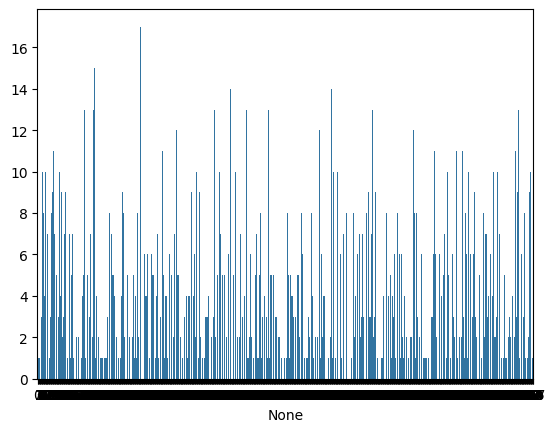

In [11]:
sns.barplot(x=tmp.index, y=tmp.values)

In [12]:
# 결측치
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [14]:
# 데이터 분리; 이전과는 다르게 내장 함수를 이용해서 쉽게 분리한다.

from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.1, random_state=SEED, stratify=df['Outcome'])
# 훈련 테스트 비율 9: 1
# stratify를 쓰면 해당 파라미터의 비율이 잘 맞게 나눠준다
train.shape, test.shape

((691, 9), (77, 9))

# X, y 변수 분리

In [15]:
X_train = train.drop('Outcome', axis=1)
y_train = train['Outcome']

X_test = test.drop('Outcome', axis=1)
y_test = test['Outcome']

In [16]:
col_list = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
median_list = []

for col in col_list:
  med = X_train[col].median()
  X_train.loc[X_train[col] == 0, col] = med # 결측치가 있는 데이터 (0)를 median으로 설정
  median_list.append(med)

In [17]:
X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
255,1,113,64,35,40,33.6,0.543,21
125,1,88,30,42,99,55.0,0.496,26
46,1,146,56,23,40,29.7,0.564,29
312,2,155,74,17,96,26.6,0.433,27
519,6,129,90,7,326,19.6,0.582,60


## scaling

In [18]:
from sklearn.preprocessing import StandardScaler # 평균이 0, 표준편차가 1인 데이터로 변경하는 녀석

ss = StandardScaler()
X_train = ss.fit_transform(X_train)

X_train

array([[-0.8500507 , -0.28476158, -0.66987668, ...,  0.18416848,
         0.2110448 , -1.05618828],
       [-0.8500507 , -1.11097193, -3.45488511, ...,  3.36345057,
         0.0685775 , -0.63068332],
       [-0.8500507 ,  0.80583607, -1.32517278, ..., -0.39523339,
         0.27470041, -0.37538035],
       ...,
       [-0.8500507 , -0.8135362 , -0.1784046 , ...,  0.85270911,
        -0.77410146, -0.29027936],
       [-1.1456647 , -0.58219731, -0.66987668, ...,  0.18416848,
         0.11101457, -0.97108729],
       [ 0.03679132,  0.73973924, -1.16134875, ..., -0.42494631,
        -0.56494733,  0.30542758]])

In [19]:
ss.mean_
ss.var_

array([1.14432658e+01, 9.15585198e+02, 1.49040674e+02, 8.39423684e+01,
       9.95053998e+03, 4.53074291e+01, 1.08834177e-01, 1.38079995e+02])

In [20]:
y_train_e = y_train.to_numpy()

# 모델 학습

In [21]:
from sklearn.svm import SVC

clf = SVC(random_state= SEED)
clf.fit(X_train, y_train_e)

SVC(random_state=42)

# 검증

In [22]:
# 테스트 값 전처리부터

X_test = test.drop('Outcome', axis=1)
y_test = test['Outcome']

for i, col in enumerate(col_list):
  X_test.loc[X_test[col] == 0, col] = median_list[i] # test에 있는 데이터라도 train에 있는 median 값을 사용해야 한다
  median_list.append(med)

In [23]:
X_test = ss.transform(X_test)
X_test

array([[-5.54436689e-01, -1.11097193e+00,  1.49243450e-01,
        -9.00023374e-01, -4.56615415e-01, -4.99228601e-01,
        -7.40758045e-01, -9.71087289e-01],
       [-1.14566470e+00,  7.72787653e-01, -1.45805753e-02,
        -4.63437799e-01, -5.86938102e-01,  1.75895307e+00,
         4.74760878e-01, -2.05178367e-01],
       [ 1.81047536e+00,  2.44013034e-01, -8.33700702e-01,
         9.55465319e-01, -5.86938102e-01,  1.31325932e+00,
        -9.81395619e-02,  3.90528572e-01],
       [ 3.67913235e-02,  3.43158275e-01, -1.45805753e-02,
        -4.63437799e-01, -5.86938102e-01,  8.01732753e-02,
        -5.19479039e-01, -8.85986297e-01],
       [ 3.32405330e-01, -3.50858412e-01, -1.45805753e-02,
         8.22941695e-02, -5.86938102e-01, -1.25690798e+00,
        -2.01201017e-01, -5.45582332e-01],
       [-1.14566470e+00, -4.83052067e-01,  3.13067475e-01,
        -4.63437799e-01, -5.86938102e-01,  1.92237411e+00,
         6.44509157e-01, -8.00885306e-01],
       [-8.50050695e-01,  8.388844

In [24]:
y_test_e = y_test.to_numpy()
y_test_e

array([0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0])

In [25]:
print(X_test.shape, y_test_e.shape)
print(type(X_test), type(y_test_e))

(77, 8) (77,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [26]:
y_pred = clf.predict(X_test)
y_pred

array([0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [27]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

print('accuracy: ',accuracy_score(y_test_e, y_pred).round(2))
print('recall_score: ', recall_score(y_test_e, y_pred).round(2))
print('precision_score: ',precision_score(y_test_e, y_pred).round(2))
print('f1_score: ', f1_score(y_test_e, y_pred).round(2))


accuracy:  0.77
recall_score:  0.59
precision_score:  0.7
f1_score:  0.64


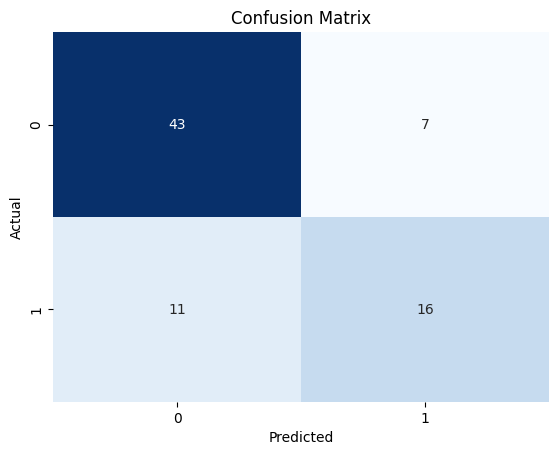

In [28]:
from sklearn.metrics import confusion_matrix

cfm = confusion_matrix(y_test_e, y_pred)
s = sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues', cbar=False)
s.set(xlabel='Predicted', ylabel='Actual')
plt.title('Confusion Matrix')
plt.show()

# 모델 튜닝

In [32]:
from sklearn.model_selection import GridSearchCV

params_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['sigmoid']
}

clf = SVC(random_state= SEED)
grid_search = GridSearchCV(estimator=clf, param_grid=params_grid, cv=5, n_jobs= -1, refit= True, verbose= 2, return_train_score= True)
grid_search.fit(X_train, y_train_e)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END ...............C=0.001, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ...............C=0.001, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ...............C=0.001, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ...............C=0.001, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ................C=0.001, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ...............C=0.001, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ................C=0.001, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .................C=0.001, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .................C=0.001, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .................C=0.001, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=0.001, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=0.001, gamma=1, k

GridSearchCV(cv=5, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                         'kernel': ['sigmoid']},
             return_train_score=True, verbose=2)

In [33]:
grid_search.best_estimator_

SVC(C=1, gamma=0.01, kernel='sigmoid', random_state=42)

In [34]:
grid_search.best_params_

{'C': 1, 'gamma': 0.01, 'kernel': 'sigmoid'}

In [35]:
y_pred = grid_search.best_estimator_.predict(X_test)
y_pred

array([0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [36]:
print('accuracy: ',accuracy_score(y_test_e, y_pred).round(2))
print('recall_score: ', recall_score(y_test_e, y_pred).round(2))
print('precision_score: ',precision_score(y_test_e, y_pred).round(2))
print('f1_score: ', f1_score(y_test_e, y_pred).round(2))

accuracy:  0.77
recall_score:  0.59
precision_score:  0.7
f1_score:  0.64
